文本情緒分析
Stock-Market Sentiment Dataset 推特上股票消息情緒分類
1.	將股票市場的評論分成[‘negative’,’positive’]兩個類別
2.	資料來源 http://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset
3.	做word2vec 跟 bert 兩種模型的比較，使用colab撰寫

In [ ]:
import pandas as pd
from collections import Counter

# 載入數據集
df = pd.read_csv('stock_data.csv')
df.head(10)

# 查看資料集的基本統計資訊
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB
None


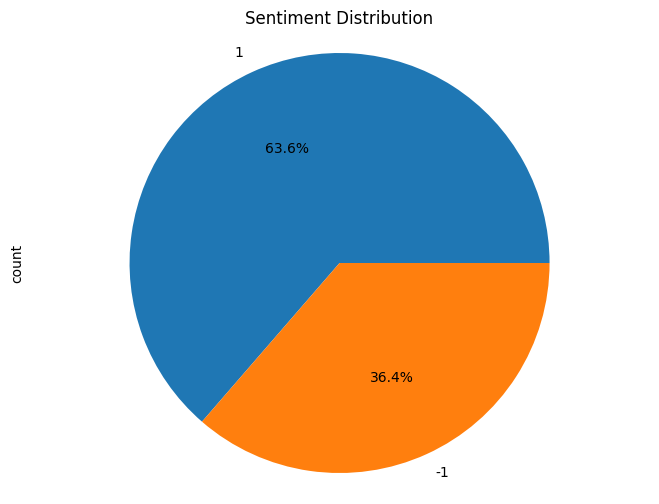

In [ ]:
import matplotlib.pyplot as plt

# 計算每個標籤的數量
label_counts = df['Sentiment'].value_counts()

# 繪製餅圖
plt.figure(figsize=(8, 6))
label_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

In [ ]:
# 檢查缺失值
print(df.isnull().sum())

Text         0
Sentiment    0
dtype: int64


In [ ]:
# 計算每個文本出現的次數
text_counts = df['Text'].value_counts()

# 找出出現次數最多的文本
most_common_text = text_counts.idxmax()

print(f"出現次數最多的文本是: {most_common_text}")

# 統計分類標籤 -1 和 1 出現的次數
label_counts = df.groupby('Sentiment').size()

# 找出 -1 出現最多的文本特徵 10 個
negative_texts = df[df['Sentiment'] == -1]['Text']
negative_words = ' '.join(negative_texts).split()
negative_word_counts = Counter(negative_words)
top_negative_words = negative_word_counts.most_common(10)
print("出現次數最多的 -1 文本特徵:")
print(top_negative_words)

# 找出 1 出現最多的文本特徵 10 個
positive_texts = df[df['Sentiment'] == 1]['Text']
positive_words = ' '.join(positive_texts).split()
positive_word_counts = Counter(positive_words)
top_positive_words = positive_word_counts.most_common(10)
print("出現次數最多的 1 文本特徵:")
print(top_positive_words)

出現次數最多的文本是: Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts
出現次數最多的 -1 文本特徵:
[('the', 692), ('to', 609), ('a', 447), ('AAP', 395), ('on', 362), ('in', 320), ('of', 316), ('and', 310), ('is', 307), ('for', 283)]
出現次數最多的 1 文本特徵:
[('the', 1104), ('to', 1059), ('a', 833), ('on', 670), ('of', 628), ('for', 585), ('in', 571), ('and', 540), ('is', 504), ('-', 494)]


WORD2VEC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Class distribution: Sentiment
 1    3685
-1    2106
Name: count, dtype: int64
Accuracy: 0.78
              precision    recall  f1-score   support

          -1       0.78      0.81      0.79       385
           1       0.78      0.75      0.76       352

    accuracy                           0.78       737
   macro avg       0.78      0.78      0.78       737
weighted avg       0.78      0.78      0.78       737



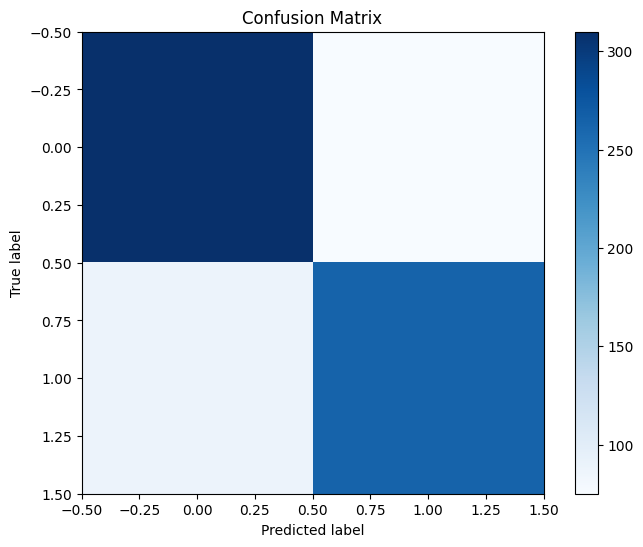

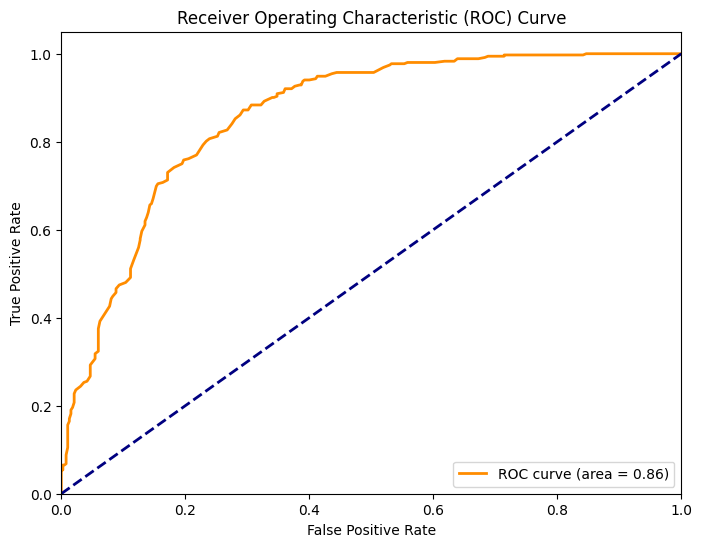

In [ ]:
# Word2vec 0.80

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# 載入數據集
df = pd.read_csv('stock_data.csv')

# 轉換所有文本為小寫
df['Text'] = df['Text'].str.lower()

# 移除標點符號和特殊字符 77%
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)

# 移除停用詞
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))

# 進行詞幹提取
stemmer = PorterStemmer()
df['Text'] = df['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))

# 訓練 word2vec 模型
model = Word2Vec(df['Text'], min_count=4, vector_size=120, window=8, workers=4)

# 將文本轉換為向量
def get_text_vector(text):
    words = text
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

X = df['Text'].apply(get_text_vector).tolist()
y = df['Sentiment']

# 檢查樣本分布
print('Class distribution:', df['Sentiment'].value_counts())

# 使用SMOTE過採樣處理樣本不平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 拆分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

# 訓練模型 (使用Random Forest)
model = RandomForestClassifier(n_estimators=250, random_state=42)
model.fit(X_train, y_train)

# 評估模型
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 輸出分類報告
print(classification_report(y_test, y_pred))

# 繪製混淆矩陣
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 繪製ROC曲線和AUC指標
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

BERT

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Class distribution: Sentiment
 1    3685
-1    2106
Name: count, dtype: int64
Random Forest Accuracy: 0.79
              precision    recall  f1-score   support

          -1       0.80      0.79      0.80       385
           1       0.77      0.79      0.78       352

    accuracy                           0.79       737
   macro avg       0.79      0.79      0.79       737
weighted avg       0.79      0.79      0.79       737



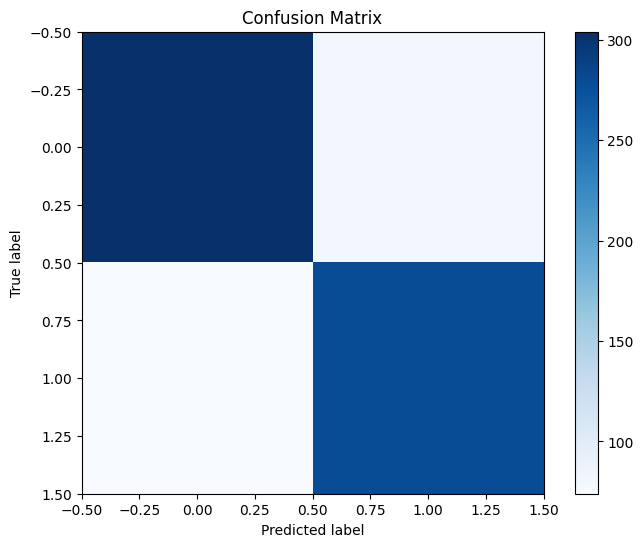

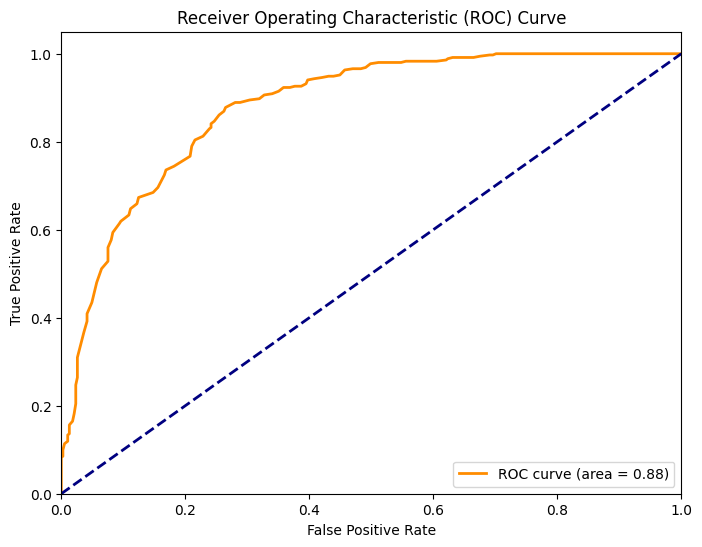

In [ ]:
# BERT**********************

import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# 載入數據集
df = pd.read_csv('stock_data.csv')

# 轉換所有文本為小寫
df['Text'] = df['Text'].str.lower()

# # 移除標點符號和特殊字符 77%
# df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)

# 移除停用詞
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))

# 進行詞幹提取
stemmer = PorterStemmer()
df['Text'] = df['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))

# 載入BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# 將文本轉換為BERT特徵
def get_bert_features(text):
    input_ids = tokenizer.encode(text, return_tensors='pt')
    outputs = model(input_ids)[1]
    return outputs.detach().numpy().flatten()

X = df['Text'].apply(get_bert_features).tolist()
y = df['Sentiment']

# 檢查樣本分布
print('Class distribution:', df['Sentiment'].value_counts())

# 使用SMOTE過採樣處理樣本不平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 拆分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

# 訓練模型 (使用Random Forest)
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 評估模型
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy:.2f}')

# 輸出分類報告
print(classification_report(y_test, y_pred))


# 繪製混淆矩陣
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 繪製ROC曲線和AUC指標
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

WORD2VEC 不同模型比較

Class distribution: Sentiment
 1    3685
-1    2106
Name: count, dtype: int64
Random Forest Accuracy: 0.79
Logistic Regression Accuracy: 0.61
SVM Accuracy: 0.59
GBDT Accuracy: 0.67


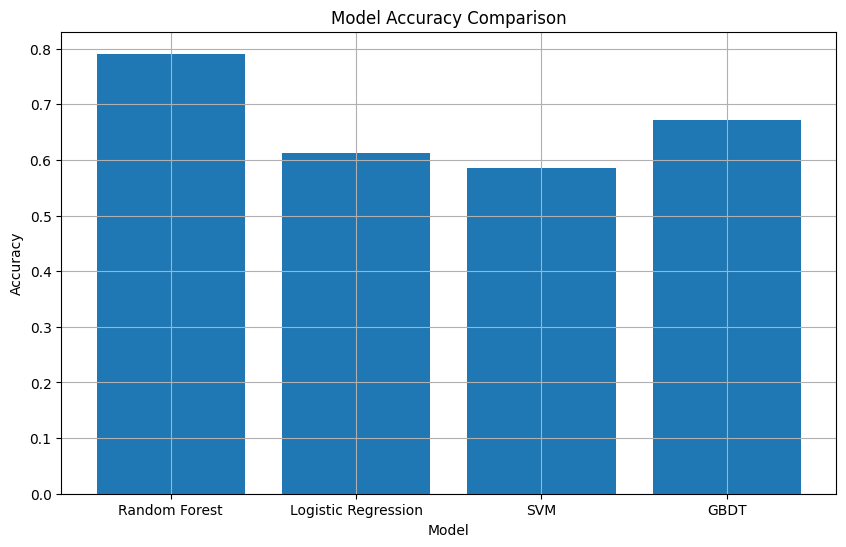

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 載入數據集
df = pd.read_csv('stock_data.csv')

# 訓練 word2vec 模型
model = Word2Vec(df['Text'], min_count=4, vector_size=120, window=8, workers=4)

# 將文本轉換為向量
def get_text_vector(text):
    words = text
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

X = df['Text'].apply(get_text_vector).tolist()
y = df['Sentiment']

# 檢查樣本分布
print('Class distribution:', df['Sentiment'].value_counts())

# 使用SMOTE過採樣處理樣本不平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 拆分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

# 訓練模型 (使用Random Forest)
rf_model = RandomForestClassifier(n_estimators=250, random_state=42)
rf_model.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))
print(f'Random Forest Accuracy: {rf_acc:.2f}')

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, lr_model.predict(X_test))
print(f'Logistic Regression Accuracy: {lr_acc:.2f}')

# SVM
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
svm_acc = accuracy_score(y_test, svm_model.predict(X_test))
print(f'SVM Accuracy: {svm_acc:.2f}')

# GBDT
gbdt_model = GradientBoostingClassifier(random_state=42)
gbdt_model.fit(X_train, y_train)
gbdt_acc = accuracy_score(y_test, gbdt_model.predict(X_test))
print(f'GBDT Accuracy: {gbdt_acc:.2f}')

# 準確率結果
acc_results = [rf_acc, lr_acc, svm_acc, gbdt_acc]
model_names = ['Random Forest', 'Logistic Regression', 'SVM', 'GBDT']

# 畫質方圖
plt.figure(figsize=(10, 6))
plt.bar(model_names, acc_results)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

BERT 不同模型比較

Class distribution: Sentiment
 1    3685
-1    2106
Name: count, dtype: int64
Random Forest Accuracy: 0.80


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.71
SVM Accuracy: 0.66
GBDT Accuracy: 0.71


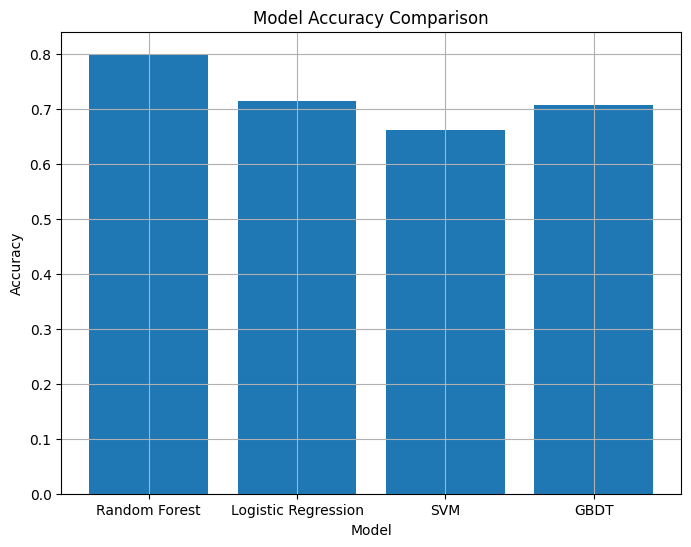

In [ ]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 載入數據集
df = pd.read_csv('stock_data.csv')

# 載入BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# 將文本轉換為BERT特徵
def get_bert_features(text):
    input_ids = tokenizer.encode(text, return_tensors='pt')
    outputs = model(input_ids)[1]
    return outputs.detach().numpy().flatten()

X = df['Text'].apply(get_bert_features).tolist()
y = df['Sentiment']

# 檢查樣本分布
print('Class distribution:', df['Sentiment'].value_counts())

# 使用SMOTE過採樣處理樣本不平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 拆分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

# 訓練並評估模型
models = [
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('GBDT', GradientBoostingClassifier(random_state=42))
]

accuracies = []
for name, model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)
  print(f'{name} Accuracy: {accuracy:.2f}')

# 繪製模型準確率圖表
plt.figure(figsize=(8, 6))
plt.bar([model[0] for model in models], accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.show()

補充 TF-IDF

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


Class distribution: Sentiment
 1    3685
-1    2106
Name: count, dtype: int64
Accuracy: 0.86
              precision    recall  f1-score   support

          -1       0.87      0.86      0.87       385
           1       0.85      0.86      0.85       352

    accuracy                           0.86       737
   macro avg       0.86      0.86      0.86       737
weighted avg       0.86      0.86      0.86       737



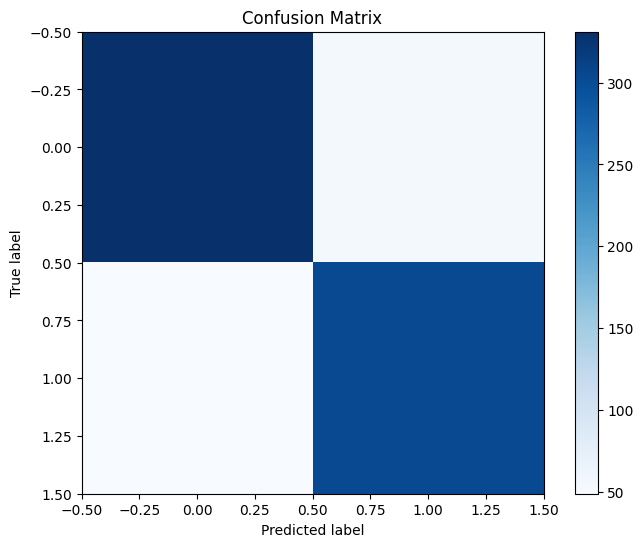

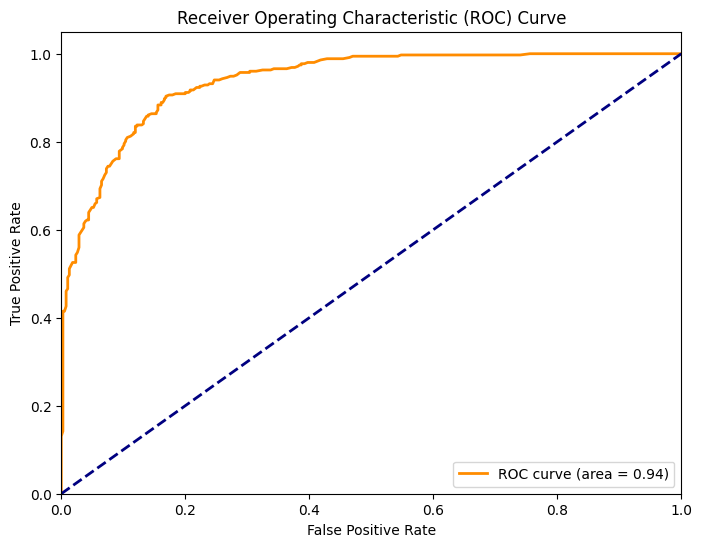

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 載入數據集
df = pd.read_csv('stock_data.csv')

# 將文本轉換為 TF-IDF 向量
tfidf = TfidfVectorizer(min_df=4, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1)
X = tfidf.fit_transform(df['Text']).toarray()
y = df['Sentiment']

# 檢查樣本分布
print('Class distribution:', df['Sentiment'].value_counts())

# 使用SMOTE過採樣處理樣本不平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 拆分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

# 訓練模型 (使用Random Forest)
model = RandomForestClassifier(n_estimators=250, random_state=42)
model.fit(X_train, y_train)

# 評估模型
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 輸出分類報告
print(classification_report(y_test, y_pred))

# 繪製混淆矩陣
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 繪製ROC曲線和AUC指標
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# # 安裝必要的套件
# # !pip install transformers
# # !pip install -U gensim

# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
# import torch
# from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
# from tqdm.notebook import tqdm

# # 讀取資料
# df = pd.read_csv("stock_data.csv")

# # 將標籤從-1改為0，1改為1
# df['Sentiment'] = df['Sentiment'].replace(-1, 0)

# # 分割資料
# X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42)

# # 訓練Word2Vec模型
# word2vec_model = Word2Vec(sentences=[text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4)

# # 將文字轉換成Word2Vec向量
# def text_to_vector(text):
#     words = text.split()
#     vectors = []
#     for word in words:
#         if word in word2vec_model.wv:
#             vectors.append(word2vec_model.wv[word])
#     if vectors:
#         return sum(vectors) / len(vectors)
#     else:
#         return [0] * 100

# X_train_word2vec = [text_to_vector(text) for text in X_train]
# X_test_word2vec = [text_to_vector(text) for text in X_test]

# # 訓練Random Forest模型
# rf_model = RandomForestClassifier()
# rf_model.fit(X_train_word2vec, y_train)
# rf_predictions = rf_model.predict(X_test_word2vec)
# rf_accuracy = accuracy_score(y_test, rf_predictions)

# print("Word2Vec + Random Forest Accuracy:", rf_accuracy)
# print(classification_report(y_test, rf_predictions))

# # 使用BERT模型
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# model.to(device)

# # 資料前處理
# max_length = 128
# encoded_data_train = tokenizer.batch_encode_plus(
#     X_train.tolist(),
#     add_special_tokens=True,
#     return_attention_mask=True,
#     pad_to_max_length=True,
#     max_length=max_length,
#     return_tensors='pt'
# )

# encoded_data_test = tokenizer.batch_encode_plus(
#     X_test.tolist(),
#     add_special_tokens=True,
#     return_attention_mask=True,
#     pad_to_max_length=True,
#     max_length=max_length,
#     return_tensors='pt'
# )

# input_ids_train = encoded_data_train['input_ids']
# attention_masks_train = encoded_data_train['attention_mask']
# labels_train = torch.tensor(y_train.tolist())

# input_ids_test = encoded_data_test['input_ids']
# attention_masks_test = encoded_data_test['attention_mask']
# labels_test = torch.tensor(y_test.tolist())

# dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
# dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

# batch_size = 2
# dataloader_train = DataLoader(dataset_train,sampler=RandomSampler(dataset_train),batch_size=batch_size)

# dataloader_test = DataLoader(dataset_test,sampler=SequentialSampler(dataset_test),batch_size=batch_size)

# # 設定訓練參數
# optimizer = AdamW(model.parameters(),lr=1e-5,eps=1e-8)

# epochs = 3

# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=len(dataloader_train)*epochs)

# # 訓練BERT模型
# for epoch in tqdm(range(1, epochs+1)):
#     model.train()
#     loss_train_total = 0
#     progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
#     for batch in progress_bar:
#         model.zero_grad()
#         batch = tuple(b.to(device) for b in batch)
#         inputs = {'input_ids':      batch[0],
#                   'attention_mask': batch[1],
#                   'labels':         batch[2],
#                  }
#         outputs = model(**inputs)
#         loss = outputs[0]
#         loss_train_total += loss.item()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
#         scheduler.step()
#         progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

#     tqdm.write(f'\nEpoch {epoch}')

#     loss_train_avg = loss_train_total/len(dataloader_train)
#     tqdm.write(f'Training loss: {loss_train_avg}')

#     val_loss = 0
#     predictions, true_vals = [], []
#     model.eval()
#     progress_bar = tqdm(dataloader_test, desc='Validating', disable=False)
#     for batch in progress_bar:
#         batch = tuple(b.to(device) for b in batch)
#         inputs = {'input_ids':      batch[0],
#                   'attention_mask': batch[1],
#                   'labels': batch[2],
#                  }
#         with torch.no_grad():
#             outputs = model(**inputs)
#         loss = outputs[0]
#         logits = outputs[1]
#         val_loss += loss.item()
#         preds = torch.argmax(logits, dim=1).flatten()
#         predictions.extend(preds)
#         true_vals.extend(inputs['labels'].flatten())
#     val_loss = val_loss/len(dataloader_test)
#     tqdm.write(f'Validation loss: {val_loss}')
#     print(classification_report(true_vals, predictions, labels=[0,1]))

# # 測試BERT模型
# def evaluate_bert_model(model, dataloader):
#     model.eval()
#     predictions, true_vals = [], []
#     for batch in dataloader:
#         batch = tuple(b.to(device) for b in batch)
#         inputs = {'input_ids':      batch[0],
#                   'attention_mask': batch[1],
#                   'labels':         batch[2],
#                  }
#         with torch.no_grad():
#             outputs = model(**inputs)
#         logits = outputs[1]
#         preds = torch.argmax(logits, dim=1).flatten()
#         predictions.extend(preds)
#         true_vals.extend(inputs['labels'].flatten())
#     return predictions, true_vals

# predictions, true_vals = evaluate_bert_model(model, dataloader_test)
# bert_accuracy = accuracy_score(true_vals, predictions)

# print("BERT Accuracy:", bert_accuracy)
# print(classification_report(true_vals, predictions, labels=[0,1]))


其他BERT處理

Class distribution: Sentiment
 1    3685
-1    2106
Name: count, dtype: int64
Random Forest Accuracy: 0.79


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.71
SVM Accuracy: 0.66
GBDT Accuracy: 0.71


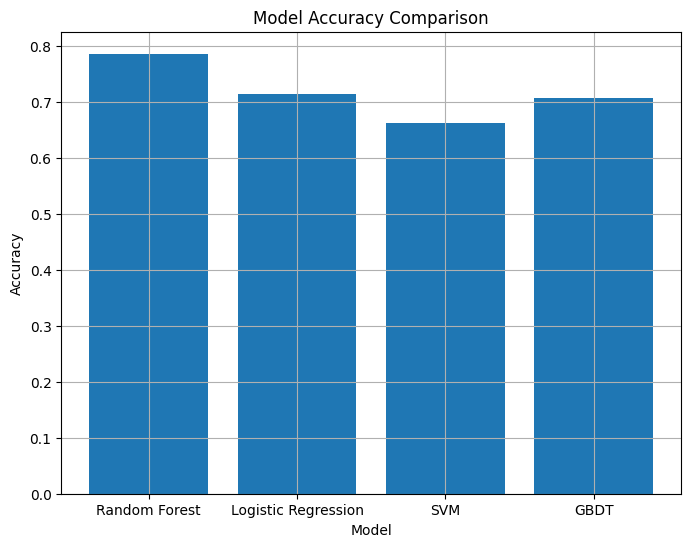

In [ ]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 載入數據集
df = pd.read_csv('stock_data.csv')

# 載入BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# 將文本轉換為BERT特徵
def get_bert_features(text):
    input_ids = tokenizer.encode(text, return_tensors='pt')
    outputs = model(input_ids)[1]
    return outputs.detach().numpy().flatten()

X = df['Text'].apply(get_bert_features).tolist()
y = df['Sentiment']

# 檢查樣本分布
print('Class distribution:', df['Sentiment'].value_counts())

# 使用SMOTE過採樣處理樣本不平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 拆分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

# 訓練並評估模型
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('GBDT', GradientBoostingClassifier(random_state=42))
]

accuracies = []
for name, model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)
  print(f'{name} Accuracy: {accuracy:.2f}')

# 繪製模型準確率圖表
plt.figure(figsize=(8, 6))
plt.bar([model[0] for model in models], accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.show()

文本處理

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Class distribution: Sentiment
 1    3685
-1    2106
Name: count, dtype: int64
Accuracy: 0.79
              precision    recall  f1-score   support

          -1       0.81      0.78      0.80       385
           1       0.77      0.80      0.78       352

    accuracy                           0.79       737
   macro avg       0.79      0.79      0.79       737
weighted avg       0.79      0.79      0.79       737



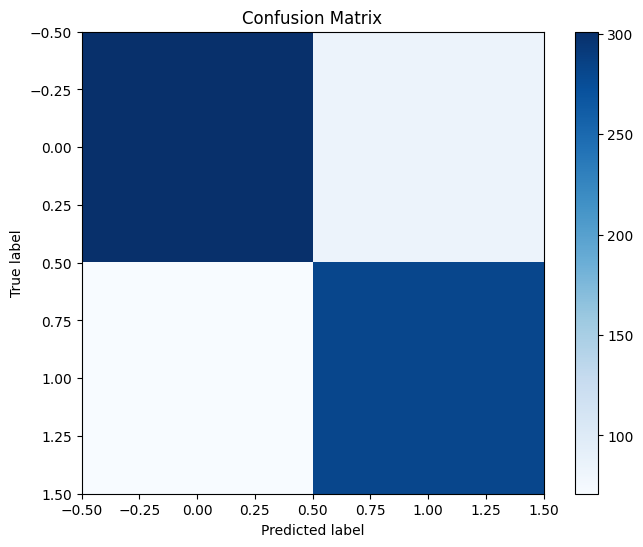

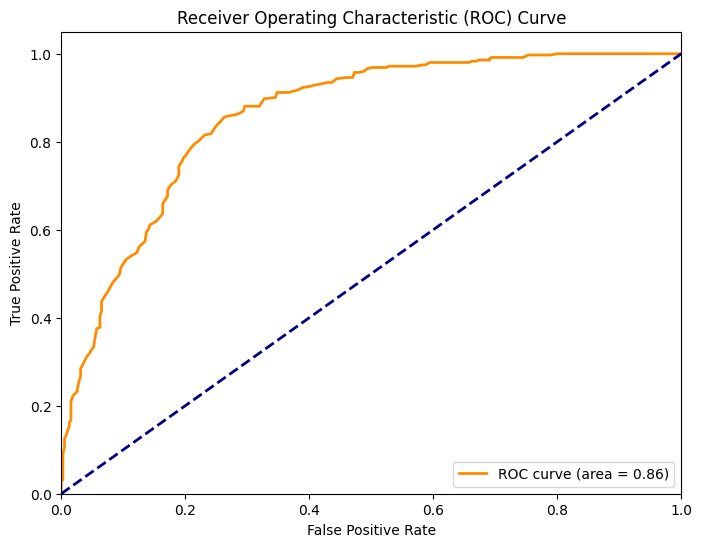

In [ ]:
# 大小寫
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# 載入數據集
df = pd.read_csv('stock_data.csv')

# 轉換所有文本為小寫
df['Text'] = df['Text'].str.lower()

# # 移除標點符號和特殊字符 總體77%
# df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)

# 移除停用詞
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))

# 進行詞幹提取
stemmer = PorterStemmer()
df['Text'] = df['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))

# 訓練 word2vec 模型
model = Word2Vec(df['Text'], min_count=4, vector_size=120, window=8, workers=4)

# 將文本轉換為向量
def get_text_vector(text):
    words = text
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(120)

X = df['Text'].apply(get_text_vector).tolist()
y = df['Sentiment']

# 檢查樣本分布
print('Class distribution:', df['Sentiment'].value_counts())

# 使用SMOTE過採樣處理樣本不平衡
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 拆分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

# 訓練模型 (使用Random Forest)
model = RandomForestClassifier(n_estimators=250, random_state=42)
model.fit(X_train, y_train)

# 評估模型
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 輸出分類報告
print(classification_report(y_test, y_pred))

# 繪製混淆矩陣
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 繪製ROC曲線和AUC指標
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE

# # 載入數據集
# df = pd.read_csv('stock_data.csv')



# # 特徵提取
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(df['Text'])
# y = df['Sentiment']

# # 拆分訓練集和測試集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 使用 SMOTE 過采樣
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# # 訓練模型 (使用Logistic Regression)
# model = LogisticRegression()
# model.fit(X_train_res, y_train_res)

# # 評估模型
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')

# # 輸出分類報告
# print(classification_report(y_test, y_pred))

# # 繪製混淆矩陣
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8,6))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.show()

# # 繪製ROC曲線和AUC指標
# y_pred_proba = model.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(8,6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# # SVM 0.65

# import pandas as pd
# import numpy as np
# from gensim.models import Word2Vec
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE

# # 載入數據集
# df = pd.read_csv('stock_data.csv')

# # 訓練 word2vec 模型
# model = Word2Vec(df['Text'], min_count=1, vector_size=100, window=5, workers=4)

# # 將文本轉換為向量
# def get_text_vector(text):
#     words = text
#     vectors = [model.wv[word] for word in words if word in model.wv]
#     if vectors:
#         return np.mean(vectors, axis=0)
#     else:
#         return np.zeros(100)

# X = df['Text'].apply(get_text_vector).tolist()
# y = df['Sentiment']

# # 拆分訓練集和測試集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 使用 SMOTE 過采樣
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# # 訓練 SVM 模型
# model = SVC(random_state=42)
# model.fit(X_train_res, y_train_res)

# # 評估模型
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')

# # 輸出分類報告
# print(classification_report(y_test, y_pred))

# # 繪製混淆矩陣
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8,6))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.show()

# # # 繪製ROC曲線和AUC指標
# # y_pred_proba = model.predict_proba(X_test)[:,1]
# # fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# # roc_auc = auc(fpr, tpr)
# # plt.figure(figsize=(8,6))
# # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# # plt.xlim([0.0, 1.0])
# # plt.ylim([0.0, 1.05])
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('Receiver Operating Characteristic (ROC) Curve')
# # plt.legend(loc="lower right")
# # plt.show()

In [ ]:
# # linear regression 0.64
# import pandas as pd
# import numpy as np
# from gensim.models import Word2Vec
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE

# # 載入數據集
# df = pd.read_csv('stock_data.csv')


# # 訓練 word2vec 模型
# model = Word2Vec(df['Text'], min_count=1, vector_size=100, window=5, workers=4)

# # 將文本轉換為向量
# def get_text_vector(text):
#     words = text
#     vectors = [model.wv[word] for word in words if word in model.wv]
#     if vectors:
#         return np.mean(vectors, axis=0)
#     else:
#         return np.zeros(100)

# X = df['Text'].apply(get_text_vector).tolist()
# y = df['Sentiment']

# # 拆分訓練集和測試集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 使用 SMOTE 過采樣
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# # 訓練模型 (使用Logistic Regression)
# model = LogisticRegression()
# model.fit(X_train_res, y_train_res)

# # 評估模型
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')

# # 輸出分類報告
# print(classification_report(y_test, y_pred))

# # 繪製混淆矩陣
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8,6))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.show()

# # 繪製ROC曲線和AUC指標
# y_pred_proba = model.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(8,6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()